In [1]:
import numpy as np
import os
os.environ.setdefault('PATH', '')
from collections import deque
import gym
from gym import spaces


USE_PIL = True
if USE_PIL:
    # you should use pillow-simd, as it is faster than stardand Pillow
    from PIL import Image
else:
    import cv2
    cv2.ocl.setUseOpenCL(False)


class TimeLimit(gym.Wrapper):
    def __init__(self, env, max_episode_steps=None):
        super(TimeLimit, self).__init__(env)
        self._max_episode_steps = max_episode_steps
        self._elapsed_steps = 0

    def step(self, ac):
        observation, reward, done, info = self.env.step(ac)
        self._elapsed_steps += 1
        if self._elapsed_steps >= self._max_episode_steps:
            done = True
            info['TimeLimit.truncated'] = True
        return observation, reward, done, info

    def reset(self, **kwargs):
        self._elapsed_steps = 0
        return self.env.reset(**kwargs)

class ClipActionsWrapper(gym.Wrapper):
    def step(self, action):
        import numpy as np
        action = np.nan_to_num(action)
        action = np.clip(action, self.action_space.low, self.action_space.high)
        return self.env.step(action)

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


class NoopResetEnv(gym.Wrapper):
    def __init__(self, env, noop_max=30):
        """Sample initial states by taking random number of no-ops on reset.
        No-op is assumed to be action 0.
        """
        gym.Wrapper.__init__(self, env)
        self.noop_max = noop_max
        self.override_num_noops = None
        self.noop_action = 0
        assert env.unwrapped.get_action_meanings()[0] == 'NOOP'

    def reset(self, **kwargs):
        """ Do no-op action for a number of steps in [1, noop_max]."""
        self.env.reset(**kwargs)
        if self.override_num_noops is not None:
            noops = self.override_num_noops
        else:
            noops = self.unwrapped.np_random.randint(1, self.noop_max + 1) #pylint: disable=E1101
        assert noops > 0
        obs = None
        for _ in range(noops):
            obs, _, done, _ = self.env.step(self.noop_action)
            if done:
                obs = self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class FireResetEnv(gym.Wrapper):
    def __init__(self, env):
        """Take action on reset for environments that are fixed until firing."""
        gym.Wrapper.__init__(self, env)
        assert env.unwrapped.get_action_meanings()[1] == 'FIRE'
        assert len(env.unwrapped.get_action_meanings()) >= 3

    def reset(self, **kwargs):
        self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(1)
        if done:
            self.env.reset(**kwargs)
        obs, _, done, _ = self.env.step(2)
        if done:
            self.env.reset(**kwargs)
        return obs

    def step(self, ac):
        return self.env.step(ac)

class EpisodicLifeEnv(gym.Wrapper):
    def __init__(self, env):
        """Make end-of-life == end-of-episode, but only reset on true game over.
        Done by DeepMind for the DQN and co. since it helps value estimation.
        """
        gym.Wrapper.__init__(self, env)
        self.lives = 0
        self.was_real_done  = True

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        self.was_real_done = done
        # check current lives, make loss of life terminal,
        # then update lives to handle bonus lives
        lives = self.env.unwrapped.ale.lives()
        if lives < self.lives and lives > 0:
            # for Qbert sometimes we stay in lives == 0 condition for a few frames
            # so it's important to keep lives > 0, so that we only reset once
            # the environment advertises done.
            done = True
        self.lives = lives
        return obs, reward, done, info

    def reset(self, **kwargs):
        """Reset only when lives are exhausted.
        This way all states are still reachable even though lives are episodic,
        and the learner need not know about any of this behind-the-scenes.
        """
        if self.was_real_done:
            obs = self.env.reset(**kwargs)
        else:
            # no-op step to advance from terminal/lost life state
            obs, _, _, _ = self.env.step(0)
        self.lives = self.env.unwrapped.ale.lives()
        return obs

class MaxAndSkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        # most recent raw observations (for max pooling across time steps)
        self._obs_buffer = np.zeros((2,)+env.observation_space.shape, dtype=np.uint8)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            if i == self._skip - 2: self._obs_buffer[0] = obs
            if i == self._skip - 1: self._obs_buffer[1] = obs
            total_reward += reward
            if done:
                break
        # Note that the observation on the done=True frame
        # doesn't matter
        max_frame = self._obs_buffer.max(axis=0)

        return max_frame, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)

class ClipRewardEnv(gym.RewardWrapper):
    def __init__(self, env):
        gym.RewardWrapper.__init__(self, env)

    def reward(self, reward):
        """Bin reward to {+1, 0, -1} by its sign."""
        return np.sign(reward)


class WarpFrame(gym.ObservationWrapper):
    def __init__(self, env, width=84, height=84, grayscale=True, dict_space_key=None):
        """
        Warp frames to 84x84 as done in the Nature paper and later work.
        If the environment uses dictionary observations, `dict_space_key` can be specified which indicates which
        observation should be warped.
        """
        super().__init__(env)
        self._width = width
        self._height = height
        self._grayscale = grayscale
        self._key = dict_space_key
        if self._grayscale:
            num_colors = 1
        else:
            num_colors = 3

        new_space = gym.spaces.Box(
            low=0,
            high=255,
            shape=(self._height, self._width, num_colors),
            dtype=np.uint8,
        )
        if self._key is None:
            original_space = self.observation_space
            self.observation_space = new_space
        else:
            original_space = self.observation_space.spaces[self._key]
            self.observation_space.spaces[self._key] = new_space
        assert original_space.dtype == np.uint8 and len(original_space.shape) == 3

    def observation(self, obs):
        if self._key is None:
            frame = obs
        else:
            frame = obs[self._key]
        if USE_PIL:
            frame = Image.fromarray(frame)
            if self._grayscale:
                frame = frame.convert("L")
            frame = frame.resize((self._width, self._height))
            frame = np.array(frame)
        else:
            if self._grayscale:
                frame = cv2.cvtColor(frame, cv2.COLOR_RGB2GRAY)
            frame = cv2.resize(
                frame, (self._width, self._height),
                interpolation=cv2.INTER_AREA
            )
        if self._grayscale:
            frame = np.expand_dims(frame, -1)

        if self._key is None:
            obs = frame
        else:
            obs = obs.copy()
            obs[self._key] = frame
        return obs

class LazyFrames(object):
    def __init__(self, frames):
        """This object ensures that common frames between the observations are only stored once.
        It exists purely to optimize memory usage which can be huge for DQN's 1M frames replay
        buffers.
        This object should only be converted to numpy array before being passed to the model.
        You'd not believe how complex the previous solution was."""
        self._frames = frames
        self._out = None

    def _force(self):
        if self._out is None:
            self._out = np.concatenate(self._frames, axis=0)
            self._frames = None
        return self._out

    def __array__(self, dtype=None):
        out = self._force()
        if dtype is not None:
            out = out.astype(dtype)
        return out

    def __len__(self):
        return len(self._force())

    def __getitem__(self, i):
        return self._force()[i]

    def count(self):
        frames = self._force()
        return frames.shape[1:frames.ndim]

    def frame(self, i):
        return self._force()[i, ...]


class FrameStack(gym.Wrapper):
    def __init__(self, env, k):
        """Stack k last frames.
        Returns lazy array, which is much more memory efficient.
        See Also
        --------
        baselines.common.atari_wrappers.LazyFrames
        """
        gym.Wrapper.__init__(self, env)
        self.k = k
        self.frames = deque([], maxlen=k)
        shp = env.observation_space.shape
        self.observation_space = spaces.Box(low=0, high=255, shape=(shp[0]*k, shp[1], shp[2]), dtype=env.observation_space.dtype)

    def reset(self):
        ob = self.env.reset()
        for _ in range(self.k):
            self.frames.append(ob)
        return self._get_ob()

    def step(self, action):
        ob, reward, done, info = self.env.step(action)
        self.frames.append(ob)
        return self._get_ob(), reward, done, info

    def _get_ob(self):
        assert len(self.frames) == self.k
        return LazyFrames(list(self.frames))

class ScaledFloatFrame(gym.ObservationWrapper):
    def __init__(self, env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=env.observation_space.shape, dtype=np.float32)

    def observation(self, observation):
        # careful! This undoes the memory optimization, use
        # with smaller replay buffers only.
        return np.array(observation).astype(np.float32) / 255.0

class SkipEnv(gym.Wrapper):
    def __init__(self, env, skip=4):
        """Return only every `skip`-th frame"""
        gym.Wrapper.__init__(self, env)
        self._skip       = skip

    def step(self, action):
        """Repeat action, sum reward, and max over last observations."""
        total_reward = 0.0
        done = None
        for i in range(self._skip):
            obs, reward, done, info = self.env.step(action)
            total_reward += reward
            if done:
                break
        return obs, total_reward, done, info

    def reset(self, **kwargs):
        return self.env.reset(**kwargs)


def make_atari(env_id, max_episode_steps=None,
               skip_noop=False, skip_maxskip=False):
    env = gym.make(env_id)
    assert 'NoFrameskip' in env.spec.id
    if not skip_noop:
        env = NoopResetEnv(env, noop_max=30)
    if not skip_maxskip:
        env = MaxAndSkipEnv(env, skip=4)
    else:
        env = SkipEnv(env, skip=4)
    if max_episode_steps is not None:
        env = TimeLimit(env, max_episode_steps=max_episode_steps)
    return env


class ImageToPyTorch(gym.ObservationWrapper):
    """
    Change image shape to CWH
    """
    def __init__(self, env):
        super(ImageToPyTorch, self).__init__(env)
        old_shape = self.observation_space.shape
        new_shape = (old_shape[-1], old_shape[0], old_shape[1])
        self.observation_space = gym.spaces.Box(
            low=0.0, high=1.0, shape=new_shape, dtype=np.uint8)

    def observation(self, observation):
        return np.swapaxes(observation, 2, 0)


def wrap_deepmind(env, episode_life=True, clip_rewards=True,
                  frame_stack=False, scale=False, pytorch_img=False,
                  frame_stack_count=4, skip_firereset=False):
    """Configure environment for DeepMind-style Atari.
    """
    if episode_life:
        env = EpisodicLifeEnv(env)
    if 'FIRE' in env.unwrapped.get_action_meanings():
        if not skip_firereset:
            env = FireResetEnv(env)
    env = WarpFrame(env)
    if pytorch_img:
        env = ImageToPyTorch(env)
    if scale:
        env = ScaledFloatFrame(env)
    if clip_rewards:
        env = ClipRewardEnv(env)
    if frame_stack:
        env = FrameStack(env, frame_stack_count)
    return env

In [2]:
from typing import Tuple, List, Union
from collections import namedtuple, deque
import numpy as np

Experience = namedtuple("Experience", 
                            field_names = ["state", "action", "reward", "done", "next_state"])

class ReplayMemory:
    """
    Original Replay Memory by Lin. Used for vanilla DQN, no prioritized Replay or bootstrapping with n>1.
    Used to store and sample experiences
    """
    def __init__(self, capacity: int) -> None:
        """
        Args: 
            capacity: size of buffer
        """
        self.buffer = deque(maxlen=capacity)

    def __len__(self):
        return len(self.buffer)

    def append(self, sample: Experience) -> None:
        """
        Append sample
        Args:
            sample: A sample of an experience to store. Experience is a tuple(state, action, reward, done, next_state)
        """
        self.buffer.append(sample)

    def sample(self, batch_size: int = 1) -> Tuple:
        """
        Return batch of buffer, randomly (uniformely).
        Args: 
            batch_size: size of batch
        """
        idxs = np.random.choice(len(self), batch_size, replace=False)

        states, actions, rewards, dones, next_states = \
            zip(*[self.buffer[idx] for idx in idxs])

        return np.array(states), np.array(actions), \
            np.array(rewards, dtype=np.float32), np.array(dones, dtype=bool), \
            np.array(next_states)

    


In [3]:
import torch
import torch.nn as nn
import numpy as np

class DQN(nn.Module):
    """
    Neural Network, choosing actions
    """
    def __init__(self, n_in, n_out):
        super(DQN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(n_in[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )

        conv_out_size = self._get_conv_out(n_in)

        self.fc = nn.Sequential(
            nn.Linear(conv_out_size, 512),
            nn.ReLU(),
            nn.Linear(512, n_out)
        )

    def _get_conv_out(self, shape):
        o = self.conv(torch.zeros(1, *shape))
        return int(np.prod(o.size()))

    def forward(self, x):
        #x = x.float() #!!! not sure. I need this, because the images are now stored as uint8 and not float32 anymore
        conv_out = self.conv(x).view(x.size()[0], -1)
        return self.fc(conv_out)



In [4]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import time
from datetime import datetime
import gym
import os


class DQN_Agent():
    """
        Vanilla DQN Agent from Mnih2013, Mnih2015
    """
    def __init__(self, env, env_name):
        #Hyperparameters
        self.hp_replay_memory_capacity = 10000
        self.hp_gamma = 0.99
        self.hp_epsilon_start = 1.0
        self.hp_epsilon_end = 0.1
        self.hp_epsilon_decay_last_frame = 100000
        self.hp_learning_rate = 0.00015
        self.hp_replay_memory_start_after = 10000
        self.hp_batch_size = 32
        self.hp_target_update_after = 10000
        
        #Training loop: Episode length differs in each game, so timesteps / frames are better!
        self.nr_of_total_frames = 2e6
        self.nr_of_evaluation_frames = 10e3
        self.nr_of_frames_before_evaluation = 50e3

        #Evaluation variables
        self.timesteps_overall = -1
        self.timesteps_after_last_episode = 0
        self.train_obtained_returns = []
        self.train_avg_returns = []
        self.eval_obtained_returns = []
        self.eval_counter = 0
        self.eval_epsilon = 0.05
        self.eval_state_samples = []

        self.env = env
        self.env_name = env_name
           
        self.replay_memory = ReplayMemory(self.hp_replay_memory_capacity)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.dtype = torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor
        self.training_start_timestamp = datetime.now(tz=None).strftime("%Y-%m-%d_%H-%M-%S")

        #Network
        self.policy_net = DQN(self.env.observation_space.shape, self.env.action_space.n).to(self.device)
        self.target_net = DQN(self.env.observation_space.shape, self.env.action_space.n).to(self.device)
        self._update_target_net()



    def _update_target_net(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())


    def _reset(self):
        """
            reset environment and reset the obtained return
        """
        self.state = self.env.reset()
        self.last_obtained_return = 0.0


    def _calc_loss(self, batch):
        """
            Calculate L1-Loss for given batch.
        """
        states, actions, rewards, dones, next_states = batch
    
        states_v = torch.from_numpy(states).to(self.device)
        next_states_v = torch.from_numpy(next_states).to(self.device)
        actions_v = torch.from_numpy(actions).to(self.device)
        rewards_v = torch.from_numpy(rewards).to(self.device)
        done_mask = torch.BoolTensor(dones).to(self.device)
        
        state_action_values = self.policy_net(states_v).gather(1, actions_v.unsqueeze(-1)).squeeze(-1)
        
        with torch.no_grad():
            next_state_values = self.target_net(next_states_v).max(1)[0]
            next_state_values[done_mask] = 0.0
        next_state_values = next_state_values.detach()
        expected_state_action_values = (next_state_values * self.hp_gamma) + rewards_v

        return F.smooth_l1_loss(state_action_values, expected_state_action_values)


    def _get_epsilon(self):
        """
            Get current value for epsilon
        """
        return max(self.hp_epsilon_end, self.hp_epsilon_start - self.timesteps_overall / self.hp_epsilon_decay_last_frame)


    def _select_action(self, eval):
        """
            Select action
        """
        epsilon = self._get_epsilon()
        if eval:
            epsilon = self.eval_epsilon

        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.from_numpy(np.array([self.state])).type(self.dtype)#.unsqueeze(0) / 255.0
            #q_vals = self.policy_net(torch.tensor(np.array([self.state], copy=False)).to(self.device))
            q_vals = self.policy_net(state)
            _, action = torch.max(q_vals, dim=1)
            action = action.item()

        return action


    def _play_step(self, eval=False):
        """
            Play one step and return if episode ended
        """
        action = self._select_action(eval)
        
        next_state, reward, done, _ = self.env.step(action)

        self.last_obtained_return += reward

        if not eval:
            exp = Experience(self.state, action, reward, done, next_state)
            self.replay_memory.append(exp)

        self.state = next_state

        return done



    def _evaluate(self, writer):
        """
            Pause Training and evaluate agent by running environment like training, 
            but without actually training the model and decreased exploration.
        """
        _eval_iteration_returns = []
        _eval_iteration_max_q_vals = []

        print("***************** Start Evaluation *****************")
        evaluation_episode = 0
        evaluation_frames = 0
        while True:
            evaluation_episode += 1
            self._reset()
            done = False
            while(not done):
                evaluation_frames += 1
                done = self._play_step(eval=True) 

            _eval_iteration_returns.append(self.last_obtained_return)
            print("Evaluation episode %d ended with return %d" %(evaluation_episode, self.last_obtained_return))      

            if evaluation_frames > self.nr_of_evaluation_frames:
                break

        _score_avg_returns = np.mean(_eval_iteration_returns)
        _score_max_q = np.mean(_eval_iteration_max_q_vals)

        print("Avg evaluation score: %f" % _score_avg_returns)
        print("***************** End Evaluation *****************")

        self.eval_counter += 1
        self.eval_obtained_returns.append(_score_avg_returns)

        writer.add_scalar('Evaluation/AvgTotalReturnPerEpisode', _score_avg_returns, self.eval_counter)
        writer.add_scalar('Evaluation/MaxPredQVals', _score_max_q, self.eval_counter)


    def train_agent(self):
        """
            Train the Agent. 
        """
        training_timestamp = datetime.now(tz=None).strftime("%Y-%m-%d_%H-%M-%S")
        writer = SummaryWriter(filename_suffix=self.env_name)
        optimizer = optim.Adam(self.policy_net.parameters(), lr=self.hp_learning_rate)

        episode = 0
        while True:
            episode += 1
            print("Start episode %d" % episode)
            self._reset()
            done = False
            ts_episode_started = time.time()

            while(not done):
                self.timesteps_overall += 1
                done = self._play_step()
                
                if len(self.replay_memory) < self.hp_replay_memory_start_after:
                    continue

                #learn
                optimizer.zero_grad()
                batch = self.replay_memory.sample(self.hp_batch_size)
                loss = self._calc_loss(batch)
                loss.backward()
                optimizer.step()

                if self.timesteps_overall % self.hp_target_update_after == 0:
                    self._update_target_net()


            speed = (self.timesteps_overall - self.timesteps_after_last_episode) / (time.time() - ts_episode_started)
            self.timesteps_after_last_episode = self.timesteps_overall
            
            print("Episode %d completed, timesteps played: %d, return: %d, speed %f, epsilon %f" 
                % (episode, self.timesteps_overall, self.last_obtained_return, speed, self._get_epsilon()))


            self.train_obtained_returns.append(self.last_obtained_return)
            self.train_avg_returns.append(np.mean(self.train_obtained_returns[-100:]))


            writer.add_scalar('Training/AvgTotalReturn', self.train_avg_returns[-1], self.timesteps_overall)
            writer.add_scalar('Training/ObtainedReturns', self.last_obtained_return, self.timesteps_overall)
            writer.add_scalar('Parameter/Epsilon', self._get_epsilon(), self.timesteps_overall)
            writer.add_scalar('Parameter/Speed', speed, self.timesteps_overall)
            

            print("Mean return of last 100 games: %f" % self.train_avg_returns[-1])
            
            #evaluate every nr_of_frames_before_evaluation
            if self.timesteps_overall >= self.nr_of_frames_before_evaluation * (self.eval_counter+1):
                self._evaluate(writer)

            if self.timesteps_overall >= self.nr_of_total_frames:
                break

        writer.close()



In [5]:
#env_name = 'PongNoFrameskip-v4'
env_name = 'PongNoFrameskip-v4'
env = make_atari(env_name, skip_noop=False, skip_maxskip=True)
env = wrap_deepmind(env, pytorch_img=True, frame_stack=False)

dqn = DQN_Agent(env, env_name)
dqn.train_agent()

Start episode 1
Episode 1 completed, timesteps played: 875, return: -21, speed 1223.003971, epsilon 0.991250
Mean return of last 100 games: -21.000000
Start episode 2
Episode 2 completed, timesteps played: 1829, return: -20, speed 1161.393375, epsilon 0.981710
Mean return of last 100 games: -20.500000
Start episode 3
Episode 3 completed, timesteps played: 2705, return: -21, speed 1261.876312, epsilon 0.972950
Mean return of last 100 games: -20.666667
Start episode 4
Episode 4 completed, timesteps played: 3508, return: -21, speed 1269.338555, epsilon 0.964920
Mean return of last 100 games: -20.750000
Start episode 5
Episode 5 completed, timesteps played: 4313, return: -21, speed 1276.719416, epsilon 0.956870
Mean return of last 100 games: -20.800000
Start episode 6
Episode 6 completed, timesteps played: 5148, return: -20, speed 1274.333765, epsilon 0.948520
Mean return of last 100 games: -20.666667
Start episode 7
Episode 7 completed, timesteps played: 6323, return: -18, speed 1249.5207

KeyboardInterrupt: 

In [6]:
pic = np.array(dqn.state)

In [9]:
pic.shape

(1, 84, 84)

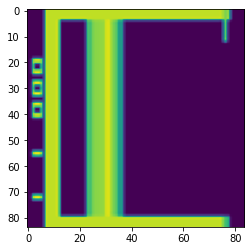

In [34]:
from PIL import Image
from matplotlib import cm
#%matplotlib inline
from matplotlib.pyplot import imshow

im = Image.fromarray(pic[3])
imshow(im)

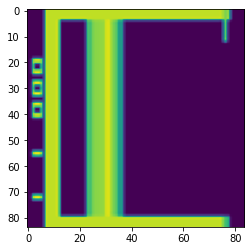

In [35]:
from PIL import Image
from matplotlib import cm
#%matplotlib inline
from matplotlib.pyplot import imshow

im = Image.fromarray(pic[0])
imshow(im)

In [44]:
dqn.replay_memory.sample(10)[0][0]

array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]], dtype=uint8)